### Objetivo:
Crear una clase RCBandPass1stOrder que:
Consista en dos etapas:

Un filtro RC High-Pass de primer orden

Un filtro RC Low-Pass de primer orden

Permita ajustar:

La frecuencia central (fc)

El ancho de banda en octavas

Aplique auto-gain opcional para mantener niveles de salida consistentes

Sea equivalente a la clase WDFRCBandPass1st en JUCE

In [2]:
from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource
from pywdf.core.circuit import Circuit
import numpy as np

class RCLowPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)
        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.C1)

    def set_cutoff(self, new_cutoff: float):
        self.cutoff = new_cutoff
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        self.R1.set_resistance(self.R)

class RCHighPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.C1 = Capacitor(self.C, self.fs)
        self.R1 = Resistor(self.R)
        self.S1 = SeriesAdaptor(self.C1, self.R1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.R1)

    def set_cutoff(self, new_cutoff: float):
        self.cutoff = new_cutoff
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        self.R1.set_resistance(self.R)

class RCBandPass1stOrder(Circuit):
    def __init__(self, fs: float, fc: float, bandwidth_octaves: float = 1.0, apply_autogain: bool = True):
        self.fs = fs
        self.fc = fc
        self.bandwidth_octaves = bandwidth_octaves
        self.apply_autogain = apply_autogain

        self._create_stages()

        super().__init__(self.hp.source, self.hp.root, self.lp.output)

    def _create_stages(self):
        ratio = 2 ** (self.bandwidth_octaves / 2.0)
        hp_cutoff = np.clip(self.fc / ratio, 20.0, self.fs * 0.45)
        lp_cutoff = np.clip(self.fc * ratio, 20.0, self.fs * 0.45)

        self.hp = RCHighPass(self.fs, hp_cutoff)
        self.lp = RCLowPass(self.fs, lp_cutoff)

    def process_sample(self, x: float) -> float:
        if self.apply_autogain:
            x *= 1.5
        return self.lp.process_sample(self.hp.process_sample(x))

    def set_cutoff(self, new_fc: float):
        self.fc = new_fc
        self._create_stages()

    def set_bandwidth(self, new_bandwidth: float):
        self.bandwidth_octaves = max(0.1, new_bandwidth)
        self._create_stages()


📊 Análisis en frecuencia y tiempo
⚙️ Parámetros

In [3]:
fs = 44100
fc = 1000           # frecuencia central
bandwidth = 1.0     # octavas

bp = RCBandPass1stOrder(fs=fs, fc=fc, bandwidth_octaves=bandwidth)


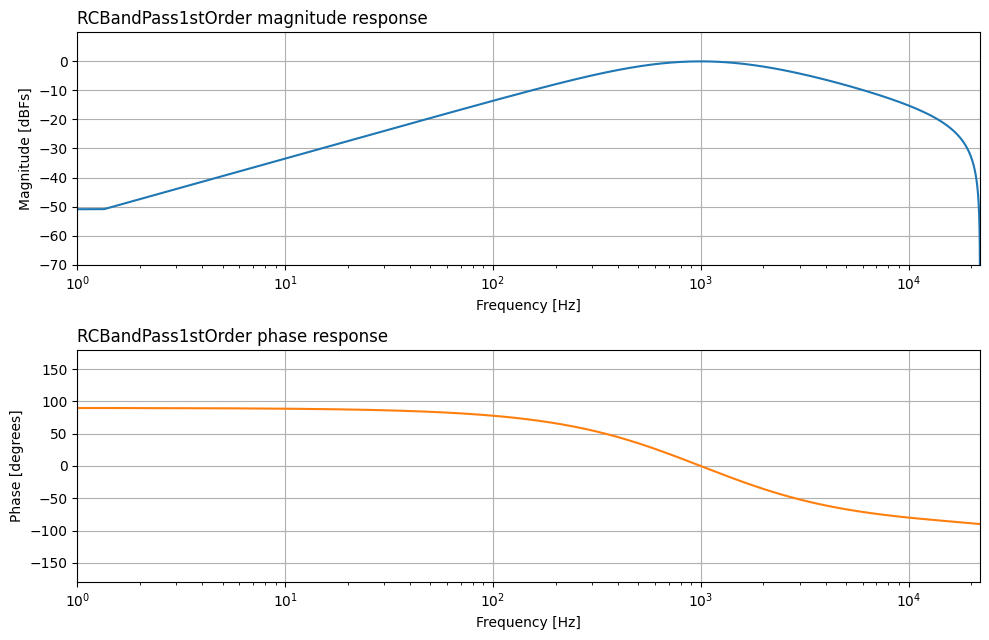

In [4]:
bp.plot_freqz()


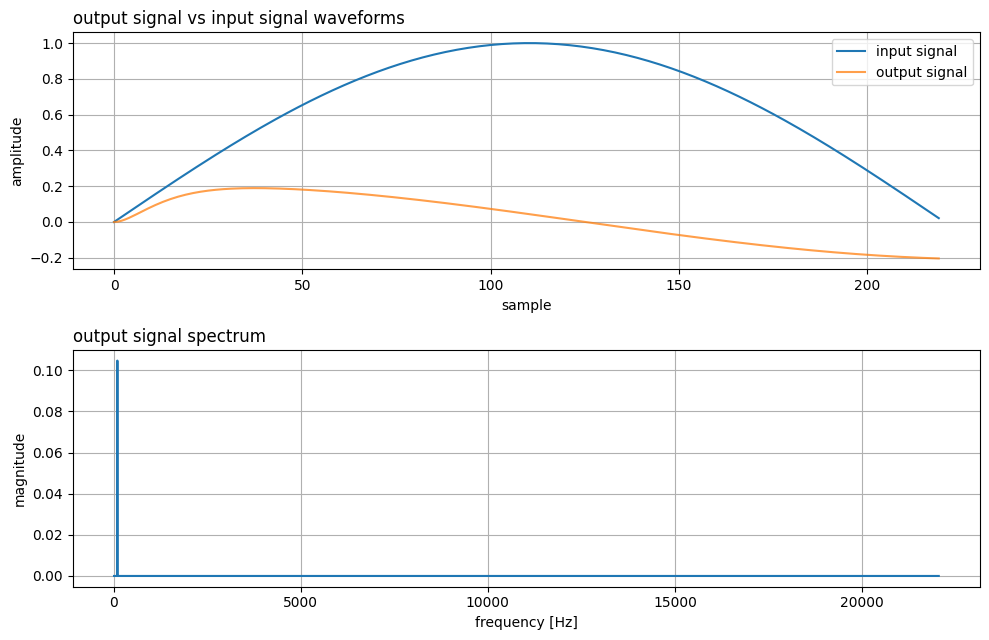

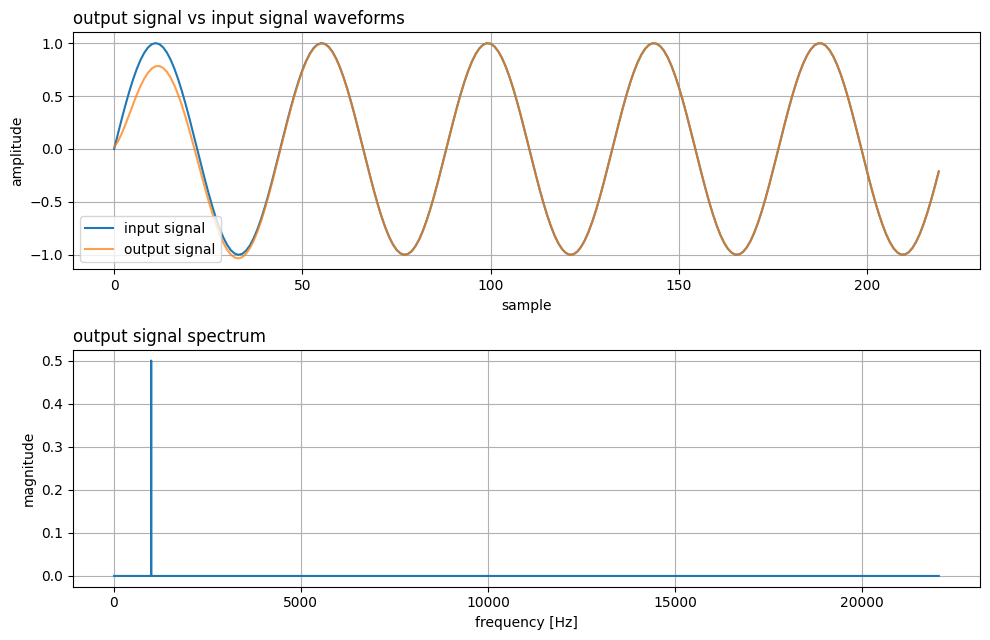

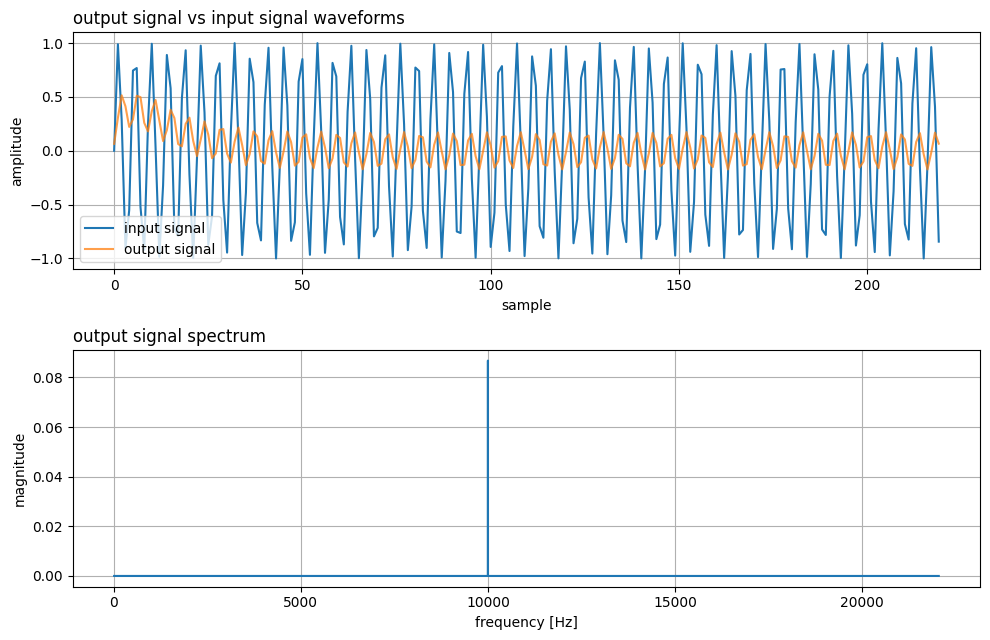

In [5]:
bp.AC_transient_analysis(freq=100, amplitude=1.0, t_ms=5)    # Muy por debajo del centro
bp.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)   # Frecuencia central
bp.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)  # Muy por encima del centro


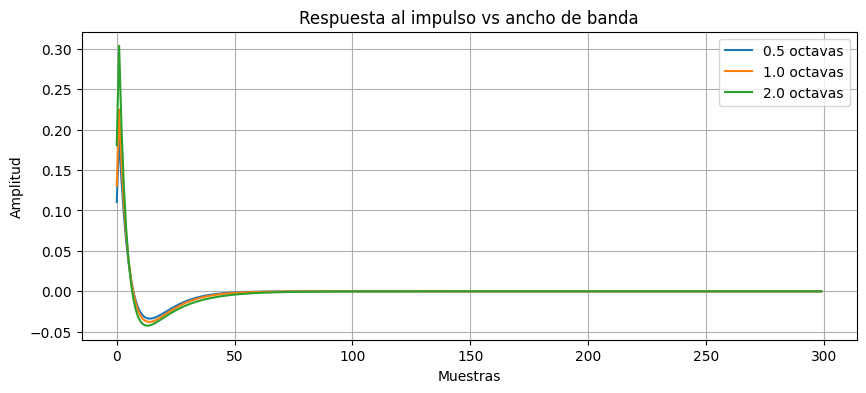

In [6]:
import matplotlib.pyplot as plt

octaves = [0.5, 1.0, 2.0]
responses = []

for bw in octaves:
    bp.set_bandwidth(bw)
    response = bp.get_impulse_response()
    responses.append((bw, response))

plt.figure(figsize=(10, 4))
for bw, r in responses:
    plt.plot(r[:300], label=f"{bw} octavas")
plt.title("Respuesta al impulso vs ancho de banda")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()
